# Visualize a trace as flamegraph

Analyzing traces with flame graphs helps quickly identify performance bottlenecks and resource-intensive code paths by visually representing the hierarchical structure and relative time spent in each function.

This notebook shows how to query span telemetry from Dynatrace via DQL, transform the result to used with a custom [D3.js](https://d3js.org/) visualization for flamegraphs. 

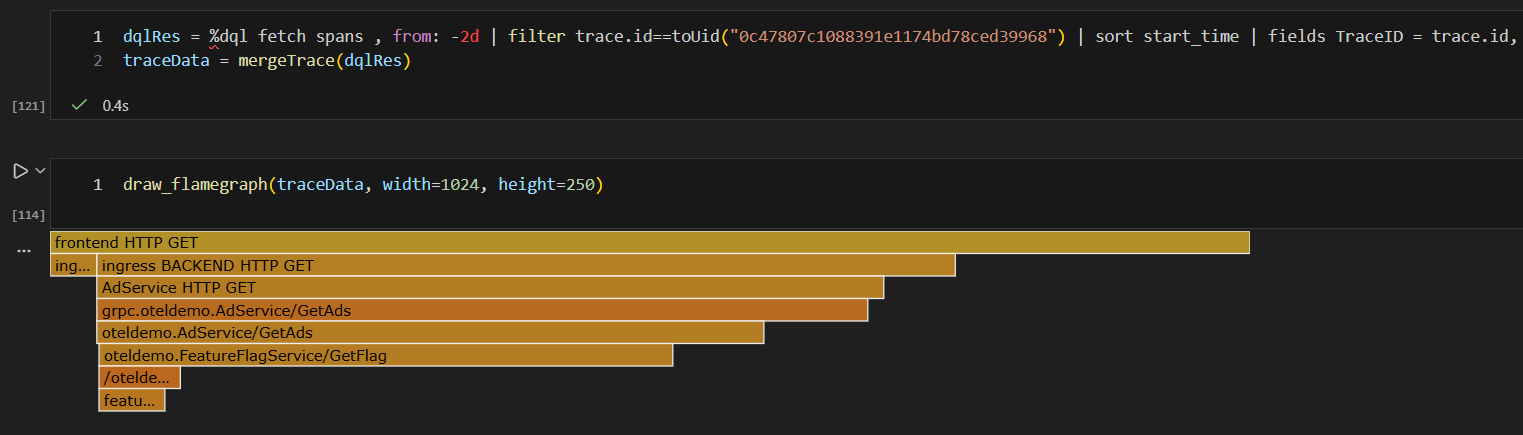

Kudos to
* https://www.stefaanlippens.net/jupyter-custom-d3-visualization.html
* https://github.com/spiermar/d3-flame-graph



## Initialize the notebook

In [ ]:
%reload_ext dqlmagic
%auth_grail 

In [115]:
# Provides necessary functions to draw flamegraphs in a Jupyter notebook
#   The main function is draw_flamegraph(data, width=1024, height=768)
# 
#       The function invokes an external javascript script to draw the flamegraph using D3js
#       The script is loaded only once per notebook session and initializes required html/css/script depenendencies
#       The function takes as input a data structure representing the flamegraph in a parent/child format
#       Example of data structure:
#       {'name': 'root', 'value': 10, 'children': [
#           {'name': 'child1', 'value': 10, 'children': [
#               {'name': 'child1.1', 'value': 10, 'children': []}
#           ]},
#           {'name': 'child2', 'value': 10, 'children': []}
#       ]}  
#
#   The data structure can be generated using the mergeTrace(trace) function
#       The function takes as input a list of spans representing an end2end transaction trace
#       Each span is represented as: {TraceID:string, SpanID:sring, ParentID:string, SpanName:string, Duration:Number(msec), Links:[{TraceId:string, SpanID:string}]}
#       The output tree is represented as: {name:string, value:Number(msec), children:[...], TraceID:string, SpanName:string}
#       The function supports multiple traces linked via span-links
#       Example of input spans:
#        [ {TraceID:"trace1", SpanID:"span1", ParentID:"", SpanName:"root", Duration:100, Links:[]},
#            {TraceID:"trace1", SpanID:"span2", ParentID:"span1", SpanName:"child1", Duration:50, Links:[]},
#            {TraceID:"trace1", SpanID:"span3", ParentID:"span2", SpanName:"child1.1", Duration:30, Links:[]},
#            {TraceID:"trace1", SpanID:"span4", ParentID:"span1", SpanName:"child2", Duration:20, Links:[]}
#        ]           

from IPython.display import display, Javascript, HTML
import json
from random import randrange

def draw_flamegraph(data, width=1024, height=768):
    display(Javascript("""
        (function(element){
            require(['drawflamegraph'], function(drawflamegraph) {
                drawflamegraph(element.get(0), %s, %d, %d);
            });
        })(element);
    """ % (json.dumps(data), width, height)))


# Transform a list of spans into a parent/child tree hierarchy to be able rendered with d3-flamegraph library
# Each span is represented as: {TraceID:string, SpanID:sring, ParentID:string, SpanName:string, Duration:Number(msec), Links:[{TraceId:string, SpanID:string}]}
# The output tree is represented as: {name:string, value:Number(msec), children:[...], TraceID:string, SpanName:string}
# The function supports multiple traces linked via span-links

## Find all root-spans, in case of having multiple traces linked via span links
def _findTraces(trace):
    traces = []
    for span in trace:
        if "ParentID" not in span: 
            print("[WARNING] Span without ParentID field found. Assuming root span.")
        if "ParentID" not in span or span['ParentID']== '': #only consider links from root spans
            s = { "name": span['SpanID'], "value": float(span['Duration']),"children": [], "TraceID":span['TraceID'], "SpanName":span['SpanName']}
            if "Links" in span:
                s["Links"]=span['Links']
            traces.append(s)    
    return traces

## Merge spans into a parent/child tree
def _findChilds(trace, currentParent):
    for span in trace:
        if span['ParentID']==currentParent['name']:
            childSpan = { "name": span['SpanID'], "value": float(span['Duration']),"children": [], "TraceID":span['TraceID'], "SpanName":span['SpanName'] }
            currentParent['children'].append(childSpan)
            _findChilds(trace, childSpan)

## Find a speciic span within a tree
def _findSpan(p, id):
    if p['name'] == id:
        return p
    else:
        for c in p['children']:
            res = _findSpan(c,id)
            if (res is not None):
                return res
    
## Set a linked span as child of it's link. Returns all the linked root spans
def _mergeFromSpanLinks(traces):
    toRemove =[]
    for t in traces:
        if "Links" in t and len(t['Links']) == 1: #No "batching" case yet
            for t2 in traces:
                parent = _findSpan(t2, t['Links'][0]['SpanID'])
                if (parent is not None):
                    parent['children'].append(t)
                    toRemove.append(t)
                    break
    return toRemove # returns list of traces that have been merged into another trace

# Merges spans of an end2end transaction into a parent/child tree, supporting also multiple traces linked via span-links (only up-links from root spans)
# trace= [{TraceID:string, SpanID:sring, ParentID:string, SpanName:string, Duration:Number(msec), Links:[{TraceId:string, SpanID:string}]}]
def mergeTrace(trace):
    traces = _findTraces(trace)
    for t in traces:
        _findChilds(trace, t)
    toRemove = _mergeFromSpanLinks(traces)
    for r in toRemove:
        traces.remove(r)
    return traces[0]

display(Javascript("require.config({paths: {d3: 'https://d3js.org/d3.v7.min', flamegraph:'https://cdn.jsdelivr.net/npm/d3-flame-graph@4.1.3/dist/d3-flamegraph.min'}});"))            
display(Javascript(filename="drawflamegraph.js"))
display(HTML(filename="flamegraph.css.html"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Query spans for a trace and render them as flamegraph

In [121]:
dqlRes = %dql fetch spans , from: -2d | filter trace.id==toUid("0c47807c1088391e1174bd78ced39968") | sort start_time | fields TraceID = trace.id, SpanID = span.id, ParentID =  if(isNull(span.parent_id),"",else:span.parent_id),  SpanName = span.name, Duration=(duration / 1000000)
traceData = mergeTrace(dqlRes)

In [ ]:
draw_flamegraph(traceData, width=1024, height=250)

<IPython.core.display.Javascript object>